In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

In [2]:
accre_unfiltered = pd.read_csv('accre-gpu-jobs-2022-v2.csv', on_bad_lines='skip')
accre_unfiltered

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE
0,32880657,malanga,arline,18.66M,2-00:00:00,00:13:13,1,2,1,pascal,0:0,COMPLETED
1,32880701,glasshouse,brady,0,05:00:00,00:00:22,1,3,1,maxwell,0:0,COMPLETED
2,32880718,glasshouse,brady,402.32M,05:00:00,00:08:57,1,3,1,maxwell,0:0,COMPLETED
3,32880719,glasshouse,brady,417.62M,20:00:00,05:09:46,1,1,1,pascal,0:0,COMPLETED
4,32880720,glasshouse,brady,450.09M,15:00:00,04:11:10,1,1,1,pascal,0:0,COMPLETED
...,...,...,...,...,...,...,...,...,...,...,...,...
336945,46754520_26,harovin,porsha,0,5-00:00:00,00:07:07,1,6,1,turing,0:0,RUNNING
336946,46754542,malanga,arline,0,2-00:00:00,00:00:00,0,2,1,pascal,0:0,PENDING
336947,46754560,malanga,arline,0,2-00:00:00,00:00:00,0,2,1,pascal,0:0,PENDING
336948,46754598,glasshouse,treva,145.24M,1-00:00:00,00:01:26,1,5,1,turing,0:0,COMPLETED


In [3]:
accre = pd.DataFrame(accre_unfiltered)

In [4]:
accre['USEDMEM'] = accre['USEDMEM'].str.replace(r'[a-zA-Z]','')

C:\Users\garre\AppData\Local\Temp\ipykernel_12708\366660924.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  accre['USEDMEM'] = accre['USEDMEM'].str.replace(r'[a-zA-Z]','')


In [5]:
accre['REQTIME'] = accre['REQTIME'].astype(str)
accre['USEDTIME'] = accre['USEDTIME'].astype(str)
accre['REQTIME'] = pd.to_timedelta(accre['REQTIME'].str.replace('-',' days '))
accre['USEDTIME'] = pd.to_timedelta(accre['USEDTIME'].str.replace('-',' days '))
accre['REQTIME'] = pd.to_timedelta(accre['REQTIME'], unit = 'S')
accre['USEDTIME'] = pd.to_timedelta(accre['USEDTIME'], unit = 'S')
accre = accre[accre['USEDMEM'].map(len) > 1]

In [6]:
accre_completed = accre[accre['STATE'] == 'COMPLETED']

In [7]:
accre_failed = accre[accre['STATE'] == 'FAILED']

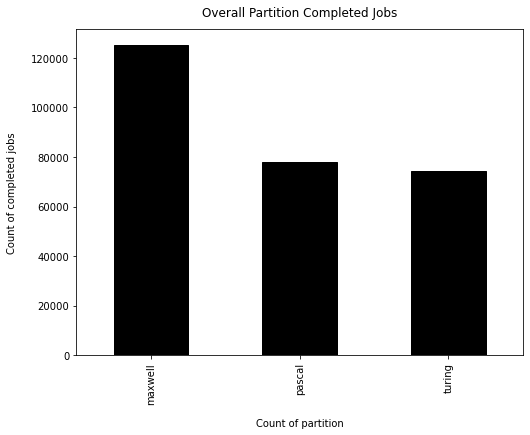

In [8]:
partitions = ['maxwell', 'pascal', 'turing']
accre_completed['PARTITION'].value_counts().loc[partitions].plot(kind = 'bar', figsize=(8, 6), edgecolor='black', color=['Black'])
plt.xlabel("Count of partition", labelpad=14)
plt.ylabel("Count of completed jobs", labelpad=14)
plt.title("Overall Partition Completed Jobs", y=1.02);

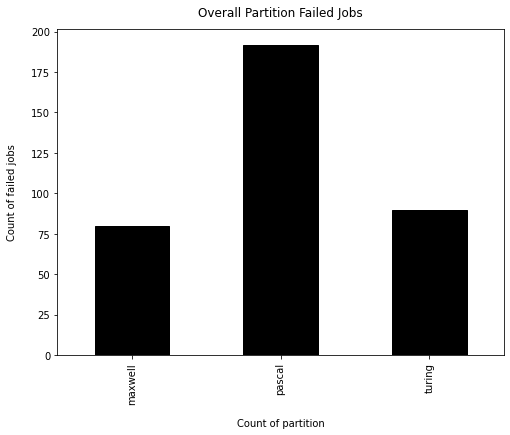

In [9]:
accre_failed['PARTITION'].value_counts().loc[partitions].plot(kind = 'bar', figsize=(8, 6), edgecolor='black', color=['Black'])
plt.xlabel("Count of partition", labelpad=14)
plt.ylabel("Count of failed jobs", labelpad=14)
plt.title("Overall Partition Failed Jobs", y=1.02);

In [10]:
accre_partition_completed = accre_completed['PARTITION'].value_counts()

In [11]:
accre_partition_failed = accre_failed['PARTITION'].value_counts()

In [12]:
accre_partition_pct = (accre_partition_failed / accre_partition_completed * 100)

In [13]:
accre_partition_pct_df = pd.DataFrame(accre_partition_pct)
accre_partition_pct_df.rename(columns = {'PARTITION': 'Percent Failed'}, inplace = True)
accre_partition_pct_df.index.name = 'Partition'
accre_partition_pct_df = accre_partition_pct_df[~np.all(accre_partition_pct_df == 0, axis=1)]
accre_partition_pct_df = accre_partition_pct_df.sort_values(by = ['Percent Failed'], ascending = True)
accre_partition_pct_df

,Percent Failed
Partition,
maxwell,0.063811
turing,0.121052
pascal,0.246882


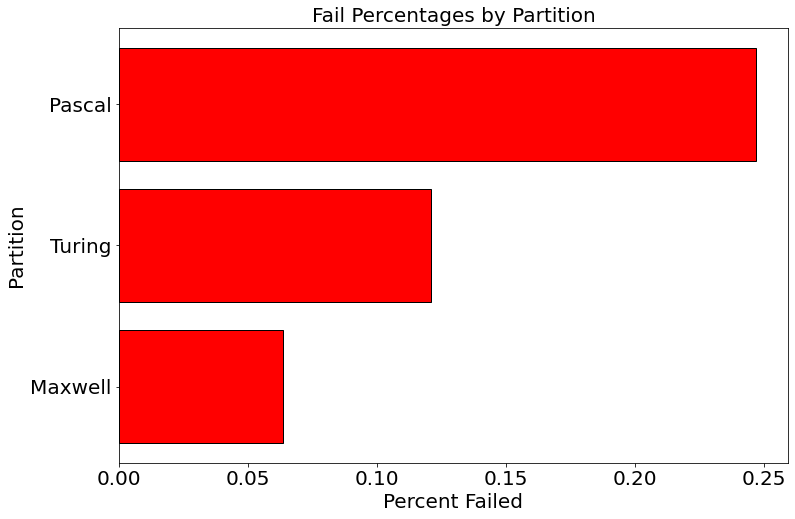

In [14]:
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(8)
x=['Maxwell', 'Turing', 'Pascal']
y=[0.063811, 0.121052, 0.246882] 
plt.rcParams.update({'font.size': 20})
plt.barh(x, y, color = 'red', edgecolor = 'black')
plt.xlabel('Percent Failed', size = 20)
plt.ylabel('Partition', size = 20)
plt.title('Fail Percentages by Partition', fontsize=20)
plt.show()

In [16]:
accre_account_completed = accre['ACCOUNT'].value_counts()

In [17]:
accre_account_failed = accre[accre['STATE'] == 'FAILED']['ACCOUNT'].value_counts()

In [18]:
accre_failed_pct = (accre_account_failed / accre_account_completed * 100).fillna(0)

In [19]:
accre_failed_pct_df = pd.DataFrame(accre_failed_pct)
accre_failed_pct_df.rename(columns = {'ACCOUNT': 'Percent Failed'}, inplace = True)
accre_failed_pct_df.index.name = 'ACCOUNTS'
accre_failed_pct_df = accre_failed_pct_df[~np.all(accre_failed_pct_df == 0, axis=1)]
accre_failed_pct_df = accre_failed_pct_df.sort_values(by = ['Percent Failed'], ascending = True)
accre_failed_pct_df

,Percent Failed
ACCOUNTS,
grisette,0.019077
pasilla,0.079177
harovin,0.088222
glasshouse,0.106384
bertanne,0.505051
clara,1.219512
almonds,3.045685
sunburst,5.780731
apple,5.913978


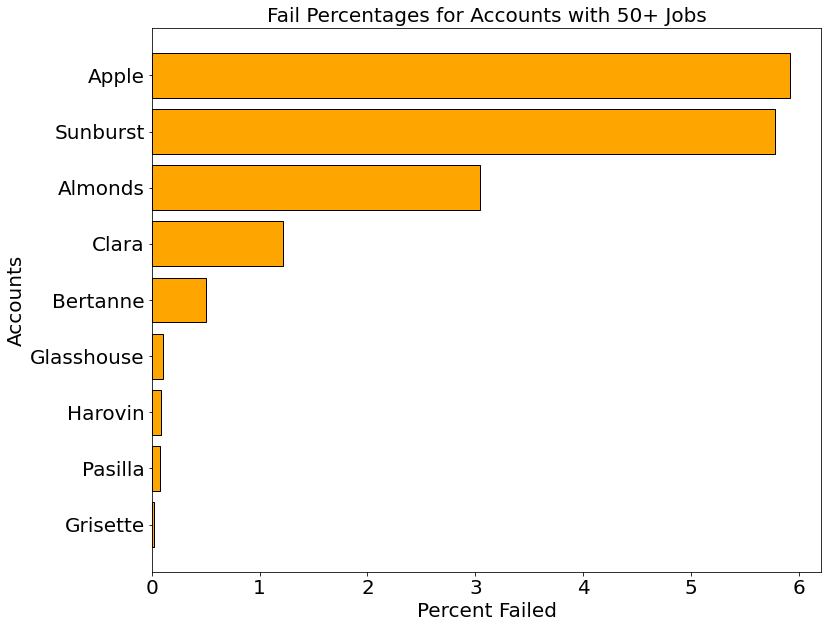

In [20]:
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(10)
x=['Grisette', 'Pasilla', 'Harovin', 'Glasshouse', 'Bertanne', 'Clara', 'Almonds', 'Sunburst', 'Apple']
y=[0.019077, 0.079177, 0.088222, 0.106384, 0.505051, 1.219512, 3.045685, 5.780731, 5.913978] 
plt.rcParams.update({'font.size': 20})
plt.barh(x, y, color = 'orange', edgecolor = 'black')
plt.xlabel('Percent Failed', size = 20)
plt.ylabel('Accounts', size = 20)
plt.title('Fail Percentages for Accounts with 50+ Jobs', fontsize=20)
plt.show()

In [21]:
accre_user_failed = accre_failed['USER'].value_counts()

In [22]:
accre_user_completed = accre_completed['USER'].value_counts()

In [23]:
accre_user_pct = (accre_user_failed / accre_user_completed * 100).fillna(0)

In [24]:
accre_user_pct_df = pd.DataFrame(accre_user_pct)
accre_user_pct_df.rename(columns = {'USER': 'Percent Failed'}, inplace = True)
accre_user_pct_df.index.name = 'Users'
accre_user_pct_df = accre_user_pct_df[~np.all(accre_user_pct_df == 0, axis=1)]
accre_user_pct_df = accre_user_pct_df.sort_values(by = ['Percent Failed'], ascending = True)
accre_user_pct_df = accre_user_pct_df.tail(14)
accre_user_pct_df

,Percent Failed
Users,
diandra,5.882353
demarcus,6.268012
penny,7.142857
wyman,7.142857
hazel,10.344828
benedict,11.267606
mel,11.830986
lea,13.807531
tommie,14.906832


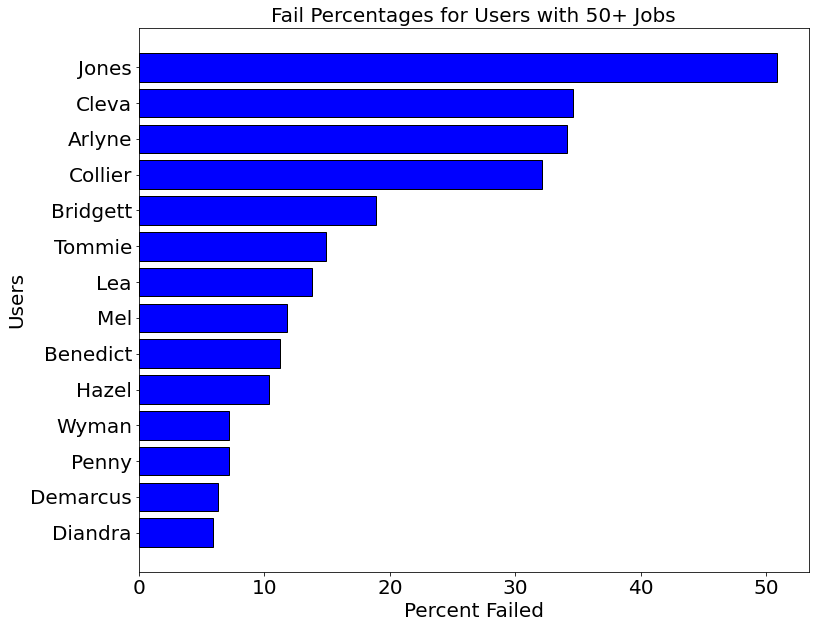

In [25]:
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(10)
x=['Jones', 'Cleva', 'Arlyne', 'Collier', 'Bridgett', 'Tommie', 'Lea', 'Mel', 'Benedict', 'Hazel', 'Wyman', 'Penny', 'Demarcus', 'Diandra'][::-1]
y=[50.847458, 34.615385, 34.090909, 32.142857, 18.918919, 14.906832, 13.807531, 11.830986, 11.267606, 10.344828, 7.142857, 7.142857, 6.268012, 5.882353][::-1]
plt.rcParams.update({'font.size': 20})
plt.barh(x, y, color = 'blue', edgecolor = 'black')
plt.xlabel('Percent Failed', size = 20)
plt.ylabel('Users', size = 20)
plt.title('Fail Percentages for Users with 50+ Jobs', fontsize=20)
plt.show()

In [26]:
total_usedtime_partition = accre.groupby(['USEDTIME', 'PARTITION']).sum()
total_usedtime_partition = total_usedtime_partition.reset_index()
total_usedtime_partition

,USEDTIME,PARTITION,NODES,CPUS,GPUS
0,0 days 00:00:00,maxwell,13,39,77
1,0 days 00:00:00,pascal,17,22,22
2,0 days 00:00:00,turing,5,40,20
3,0 days 00:00:01,maxwell,30,147,158
4,0 days 00:00:01,pascal,16,32,37
...,...,...,...,...,...
29405,5 days 00:02:24,turing,1,3,1
29406,5 days 00:04:25,turing,1,6,1
29407,5 days 00:04:26,turing,1,6,1
29408,8 days 03:15:34,pascal,3,21,16


In [27]:
maxwell =  accre[accre['PARTITION'] == 'maxwell']
maxwell_df = pd.DataFrame(maxwell)

In [28]:
maxwell = accre[accre['PARTITION'] == 'maxwell']
maxwell

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE
2,32880718,glasshouse,brady,402.32,0 days 05:00:00,0 days 00:08:57,1,3,1,maxwell,0:0,COMPLETED
244,32883667,glasshouse,miya,374.38,0 days 04:00:00,0 days 00:16:06,1,1,1,maxwell,127:0,FAILED
462,32885245,glasshouse,brady,404.90,0 days 05:00:00,0 days 00:08:57,1,3,1,maxwell,0:0,COMPLETED
467,32885270,glasshouse,brady,403.18,0 days 05:00:00,0 days 00:08:48,1,3,1,maxwell,0:0,COMPLETED
508,32885377,glasshouse,brodie,188.82,0 days 12:00:00,0 days 00:02:45,1,1,1,maxwell,0:0,COMPLETED
...,...,...,...,...,...,...,...,...,...,...,...,...
335127,46542252,glasshouse,miya,6.57,2 days 00:00:00,0 days 00:00:34,1,6,4,maxwell,0:0,COMPLETED
335856,46577601,glasshouse,tamara,1.98,3 days 08:00:00,0 days 00:00:08,2,12,6,maxwell,0:0,COMPLETED
335916,46582283,glasshouse,jonnie,2068.21,2 days 00:00:00,2 days 00:00:38,1,6,4,maxwell,0:9,CANCELLED
335984,46586533,glasshouse,tamara,1.79,3 days 08:00:00,0 days 00:00:05,2,12,6,maxwell,0:0,COMPLETED


In [29]:
maxwell['USEDMEM'].value_counts()

5.53       24156
5.54        9188
7.42        2426
7.41         359
7.53         133
           ...  
1135.12        1
1070.57        1
1180.81        1
1118.98        1
1.77           1
Name: USEDMEM, Length: 36985, dtype: int64

In [30]:
maxwell['STATE'].value_counts()

COMPLETED              125371
FAILED                     80
CANCELLED                  44
CANCELLED by 885613         4
CANCELLED by 196703         1
CANCELLED by 859439         1
Name: STATE, dtype: int64

In [31]:
maxwell.describe()

,REQTIME,USEDTIME,NODES,CPUS,GPUS
count,125501,125501,125501.000000,125501.000000,125501.000000
mean,0 days 15:05:32.416474769,0 days 00:31:02.469693468,1.002908,1.135704,1.047275
std,0 days 22:31:29.954851512,0 days 05:30:12.537301152,0.085430,1.250943,0.592964
min,0 days 00:01:00,0 days 00:00:00,1.000000,1.000000,1.000000
25%,0 days 10:00:00,0 days 00:00:10,1.000000,1.000000,1.000000
50%,0 days 10:00:00,0 days 00:03:03,1.000000,1.000000,1.000000
75%,0 days 10:00:00,0 days 00:03:45,1.000000,1.000000,1.000000
max,15 days 00:00:00,5 days 00:00:37,10.000000,80.000000,40.000000


In [32]:
pascal = accre[accre['PARTITION'] == 'pascal']
pascal_df = pd.DataFrame(pascal)

In [33]:
pascal = accre[accre['PARTITION'] == 'pascal']
pascal

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE
0,32880657,malanga,arline,18.66,2 days 00:00:00,0 days 00:13:13,1,2,1,pascal,0:0,COMPLETED
3,32880719,glasshouse,brady,417.62,0 days 20:00:00,0 days 05:09:46,1,1,1,pascal,0:0,COMPLETED
4,32880720,glasshouse,brady,450.09,0 days 15:00:00,0 days 04:11:10,1,1,1,pascal,0:0,COMPLETED
5,32880721,glasshouse,brady,403.40,3 days 12:00:00,0 days 18:49:36,1,1,1,pascal,0:0,COMPLETED
7,32880741,malanga,arline,1119.66,2 days 00:00:00,0 days 08:09:18,1,2,1,pascal,0:0,COMPLETED
...,...,...,...,...,...,...,...,...,...,...,...,...
336914,46753151,malanga,arline,29.85,2 days 00:00:00,0 days 00:14:28,1,2,1,pascal,0:0,COMPLETED
336915,46753169,malanga,arline,28.11,2 days 00:00:00,0 days 00:14:16,1,2,1,pascal,0:0,COMPLETED
336916,46753170,glasshouse,tamara,10007.76,0 days 20:00:00,0 days 00:29:16,1,5,4,pascal,0:0,COMPLETED
336917,46753171,malanga,arline,28.21,2 days 00:00:00,0 days 00:14:29,1,2,1,pascal,0:0,COMPLETED


In [34]:
pascal['USEDMEM'].value_counts()

5.53        2363
5.54        1469
7.41        1151
7.42         182
8.05         159
            ... 
9023.48        1
4.58           1
17166.96       1
12166.56       1
4.84           1
Name: USEDMEM, Length: 49225, dtype: int64

In [35]:
pascal['STATE'].value_counts()

COMPLETED              77770
FAILED                   192
CANCELLED                 58
CANCELLED by 649321       17
CANCELLED by 785491        5
CANCELLED by 159541        1
CANCELLED by 0             1
CANCELLED by 46207         1
CANCELLED by 885613        1
Name: STATE, dtype: int64

In [36]:
pascal.describe()

,REQTIME,USEDTIME,NODES,CPUS,GPUS
count,78046,78046,78046.000000,78046.000000,78046.000000
mean,2 days 00:13:59.328857340,0 days 02:59:48.791712579,1.011134,1.475732,1.163557
std,1 days 20:50:18.034890641,0 days 12:46:30.094836860,0.183548,1.558781,1.229651
min,0 days 00:01:00,0 days 00:00:00,1.000000,1.000000,1.000000
25%,0 days 10:00:00,0 days 00:02:46,1.000000,1.000000,1.000000
50%,1 days 00:00:00,0 days 00:09:04,1.000000,1.000000,1.000000
75%,3 days 00:00:00,0 days 00:36:10.750000,1.000000,2.000000,1.000000
max,12 days 00:00:00,8 days 03:15:34,15.000000,120.000000,60.000000


In [37]:
turing = accre[accre['PARTITION'] == 'turing']
turing_df = pd.DataFrame(turing)   

In [38]:
turing = accre[accre['PARTITION'] == 'turing']
turing

,JOBID,ACCOUNT,USER,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,GPUS,PARTITION,EXITCODE,STATE
80,32881540,virginia,garrett,4039.36,0 days 02:00:00,0 days 02:00:05,1,6,1,turing,0:0,COMPLETED
91,32882556,virginia,garrett,55.39,0 days 06:00:00,0 days 06:00:05,1,6,1,turing,0:0,COMPLETED
92,32882567,virginia,garrett,281.12,0 days 06:00:00,0 days 06:00:05,1,6,1,turing,0:0,COMPLETED
93,32882568,virginia,garrett,57.32,0 days 06:00:00,0 days 06:00:17,1,6,1,turing,0:0,COMPLETED
172,32883336,virginia,erla,129.24,0 days 01:00:00,0 days 00:54:52,1,6,1,turing,0:0,COMPLETED
...,...,...,...,...,...,...,...,...,...,...,...,...
336933,46753813,harovin,shannon,137.96,5 days 00:00:00,0 days 00:00:52,1,1,1,turing,0:0,COMPLETED
336934,46753820_26,harovin,porsha,5093.70,5 days 00:00:00,0 days 00:34:51,1,6,1,turing,0:0,COMPLETED
336936,46753823,harovin,shannon,156.21,5 days 00:00:00,0 days 00:04:03,1,1,1,turing,0:0,COMPLETED
336942,46754095,harovin,shannon,2820.52,5 days 00:00:00,0 days 00:11:13,1,1,1,turing,0:0,COMPLETED


In [39]:
turing['USEDMEM'].value_counts()

7.41       15491
5.54        2589
5.53        1319
5.41         988
7.42         865
           ...  
2239.59        1
2249.13        1
2220.82        1
2248.92        1
145.24         1
Name: USEDMEM, Length: 42116, dtype: int64

In [40]:
turing['STATE'].value_counts()

COMPLETED              74348
CANCELLED                194
FAILED                    90
CANCELLED by 505355       11
CANCELLED by 161909        4
OUT_OF_MEMORY              3
CANCELLED by 756088        1
CANCELLED by 785491        1
CANCELLED by 46207         1
Name: STATE, dtype: int64

In [41]:
turing['USEDMEM'].describe()

count     74653
unique    42116
top        7.41
freq      15491
Name: USEDMEM, dtype: object

In [42]:
turing.describe()

,REQTIME,USEDTIME,NODES,CPUS,GPUS
count,74653,74653,74653.000000,74653.000000,74653.000000
mean,0 days 13:35:37.233868699,0 days 02:12:53.331426734,1.003684,2.934899,1.076313
std,1 days 06:09:31.203496814,0 days 12:14:03.472997297,0.109310,2.150887,0.716668
min,0 days 00:01:00,0 days 00:00:00,1.000000,1.000000,1.000000
25%,0 days 00:30:00,0 days 00:00:14,1.000000,2.000000,1.000000
50%,0 days 01:00:00,0 days 00:03:03,1.000000,2.000000,1.000000
75%,0 days 12:00:00,0 days 00:15:45,1.000000,4.000000,1.000000
max,11 days 00:00:00,9 days 23:59:54,10.000000,80.000000,40.000000


In [43]:
maxwell['USEDMEM'].describe()

count     125501
unique     36985
top         5.53
freq       24156
Name: USEDMEM, dtype: object

In [44]:
pascal['USEDMEM'].describe()

count     78046
unique    49225
top        5.53
freq       2363
Name: USEDMEM, dtype: object

In [45]:
turing['USEDMEM'].describe()

count     74653
unique    42116
top        7.41
freq      15491
Name: USEDMEM, dtype: object

Linear Regression on the seperate partitions

In [46]:
lm = smf.ols('USEDMEM ~ GPUS', data = turing).fit()
lm.summary()

ValueError: endog has evaluated to an array with multiple columns that has shape (74653, 42116). This occurs when the variable converted to endog is non-numeric (e.g., bool or str).

In [ ]:
accre_regex = accre['USEDMEM'].str.replace(r'[a-zA-Z]','')
accre_regex

33,344 out of 125,502 entries are 5.53-5.54M memory used. Roughly 26%

In [ ]:
runtime_usage_per_gpu = turing[turing['USEDTIME' * 'GPUS']]

In [ ]:
Fig, ax = plt.subplots(figsize = (8, 6))
plt.bar(x = accre['PARTITION'], height = accre['USEDMEM'])
plt.xlabel('Continent')
plt.ylabel('Number of Countries')
plt.title('Countries per Continent')
plt.show()

In [ ]:
Fig, ax = plt.subplots(figsize=(15, 12))
accre[accre['PARTITION'] == 'maxwell'].plot(x='USEDTIME', y='USEDMEM', ax = ax)
accre[accre['PARTITION'] == 'pascal'].plot(x='USEDTIME', y='USEDMEM', ax = ax)
accre[accre['PARTITION'] == 'turing'].plot(x='USEDTIME', y='USEDMEM', ax = ax)
ax.legend(labels=['Maxwell', 'Pascal', 'Turing'])
plt.show()